# Evaluation by investment performance

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import datetime
import pickle
import sys
from pathlib import Path
import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.arima import ARIMA

sys.path.append("../../src")
from ftrends.construction import RBC

## Strategy 1.

import data

In [3]:
# endogenous
file = Path("../../data/raw/macro/ICSA.csv")
df_endog = pd.read_csv(file, index_col=0)
df_endog.index = pd.to_datetime(df_endog.index)

# exogenous
file = Path("../../data/raw/google/weekly/unemployment-office/svi_cat706.pkl")
with file.open(mode="rb") as f:
    dfs = pickle.load(f)
rbc = RBC(dfs)
df_exog = rbc.knit(direction="forward")
df_exog.index = pd.to_datetime(df_exog.index).map(lambda x: x + relativedelta(days=6))


endog, exog = "IC", "SVI"
df = pd.concat([df_endog, df_exog], axis=1) # Concatenate
df.dropna(how='any', inplace=True) # Drop NaN
df.rename(columns = dict(zip(df.columns, [endog, exog])), inplace=True) # Rename

# SP500
dfs = [] # data-frame list

for factor in ["SP500"]:
    dir = Path("../../data/raw/macro")
    _df = pd.read_csv(dir/ f"{factor}.csv")
    _df.set_index("date", inplace=True)
    _df.index = pd.to_datetime(_df.index) # Convert type of index to datetime
    dfs.append(_df)
df_sp = pd.concat(dfs, axis=1).dropna(how='any')

function

In [4]:
def seasonal_adjust(df:pd.DataFrame, factor:str, **stl_kwargs:dict):
    res = STL(df[factor], **stl_kwargs).fit()
    df["SVI"] = res.trend

def remove_covid(df:pd.DataFrame):
    covid_start = datetime.datetime(2020, 1, 1)
    return df[df.index < covid_start]

prediction

In [5]:
_df = df.copy()
_df = remove_covid(_df) # Remove COVID-19
seasonal_adjust(_df, exog) # Seasonal adjusted
_df[endog] = np.log(_df[endog]).diff(1) # logarithm ratio
_df[exog] = _df[exog].diff(1).shift(1) # difference and shift t -> t-1
_df.dropna(how="any", inplace=True)

_df = df.copy()
_df = remove_covid(_df) # Remove COVID-19
_df[endog] = np.log(_df[endog]).diff(1) # logarithm ratio
_df.dropna(how="any", inplace=True)

model = ARIMA(order=(1,0,0), seasonal_order=(0,0,0,0), maxiter=10000)
forecaster = model.fit(_df[endog])

# To save
list_df_pred = []

# model parameter
window=52
step=1

for i in range(len(_df)):
    train_start_date = _df.index.min() + relativedelta(weeks=step*i)
    train_end_date = train_start_date + relativedelta(weeks=window-1)
    test_start_date = train_end_date + relativedelta(weeks=1)
    test_end_date = train_end_date + relativedelta(weeks=step)

    if test_end_date > _df.index.max():
        break

    df_train = _df[(_df.index >= train_start_date) & (_df.index <= train_end_date)]
    df_test = _df[(_df.index >= test_start_date) & (_df.index <= test_end_date)]

    model = ARIMA(order=(1,0,0), seasonal_order=(0,0,0,0), maxiter=100000000)
    forecaster = model.fit(df_train[endog], df_train[exog])
    df_pred = forecaster.predict(X=df_test[exog], fh=pd.DatetimeIndex(df_test.index, freq='W-SAT'))
    
    list_df_pred.append(df_pred)

df_pred_model = pd.concat(list_df_pred).to_frame(name='pred')
df_pred_model.index.name = "date"
df_pred_model.index = pd.to_datetime(df_pred_model.index)

Investment performance

（例）
1. Google Trends 2022/10/16 (Sun) に 2022/10/15 (Sat)まで週次データ（$\ldots, \mathrm{SVI}_t$）が更新される．
2. 一方，2022/10/15 (Sat) 時点のICは翌週公開されるので，これを予測（$\widehat{\mathrm{IC}}_{t}$）．
3. $\widehat{ \Delta \ln \mathrm{IC}}_{t}$の値に応じて，ポジションをかえる：
   - $\widehat{ \Delta \ln \mathrm{IC}}_{t} < c$の場合，週明けの投資ウェイトを$u$倍にする．
   - $\widehat{ \Delta \ln \mathrm{IC}}_{t} > c$の場合，週明けの投資ウェイトを$d$倍にする．

（運用条件）
- リバランスは週次月曜日
- 期間は2012/10/15〜2019/12/30

In [6]:
_df_pred_model = df_pred_model.copy()
_df_sp = df_sp.copy()

_df_pred_model.index = _df_pred_model.index.map(lambda x: x + relativedelta(days=2))
_df_pred_model = _df_pred_model.shift(1)

ticker = "SP500"

_df = pd.concat([_df_pred_model, _df_sp], axis=1, join="inner")
_df[f"{ticker}_ret"] = _df[ticker].pct_change(1)
_df[f"{ticker}_cumret"] = (1 + _df[f"{ticker}_ret"]).cumprod() * 100
_df[f"{ticker}_cumret"][0] = 100
_df[f"{ticker}_downside"] = _df[f"{ticker}_ret"].apply(lambda x: x if x < 0 else 0)

def _weight(x, c, u, d):
    w = u if x < c else d
    return w

# invest

c = 0
u = 1.5
d = 1.0

for u, d in [(1.5, 1.0), (1.25, 1.0), (1.5, 0.5), (1.25, 0.75)]:

    model_name = f"M({c}, {u}, {d})"
    
    _df[f"{model_name}_weight"] = _df["pred"].apply(lambda x: _weight(x, c, u, d)).shift(1)
    _df[f"{model_name}_ret"] = _df[f"{model_name}_weight"] * _df[f"{ticker}_ret"]
    _df[f"{model_name}_cumret"] = (1 + _df[f"{model_name}_ret"]).cumprod() * 100
    _df[f"{model_name}_cumret"][0] = 100
    _df[f"{model_name}_downside"] = _df[f"{model_name}_ret"].apply(lambda x: x if x < 0 else 0)

In [7]:
def performance_metrics(ret:pd.Series):
    interval = (ret.index.max() - ret.index.min()).days / 365
    cumret = (1 + ret).cumprod() * 100
    cumret[0] = 100
    ret_downside = ret.apply(lambda x: x if x < 0 else 0)
    
    _ret = (cumret[-1]/cumret[0])**(1/interval) - 1
    risk = ret[1:].std() * np.sqrt(52)
    risk_downside = ret_downside[1:].std() * np.sqrt(52)
    
    summary = {
        "Return": _ret,
        "Risk": risk,
        "Downside Risk": risk_downside,
        "Sharpe Ratio": _ret / risk,
        "Sortino Ratio": _ret / risk_downside,
        "Max Return": _ret.max(),
        "Min Return": _ret.min()
    }
    
    return summary

In [8]:
cols = [c for c in _df.columns if c.endswith("_ret")]

summaries = {}

for col in cols:
    summary = performance_metrics(_df[col])
    summaries[col.replace("_ret", "")] = summary
    
df_summary = pd.DataFrame.from_dict(summaries)
display(df_summary)

,SP500,"M(0, 1.5, 1.0)","M(0, 1.25, 1.0)","M(0, 1.5, 0.5)","M(0, 1.25, 0.75)"
Return,0.118113,0.145904,0.132323,0.116277,0.117846
Risk,0.139850,0.184688,0.161561,0.167996,0.150489
Downside Risk,0.090513,0.122087,0.105801,0.114112,0.099990
Sharpe Ratio,0.844566,0.790004,0.819026,0.692144,0.783091
Sortino Ratio,1.304930,1.195079,1.250675,1.018969,1.178583
Max Return,0.118113,0.145904,0.132323,0.116277,0.117846
Min Return,0.118113,0.145904,0.132323,0.116277,0.117846


<AxesSubplot: xlabel='date'>

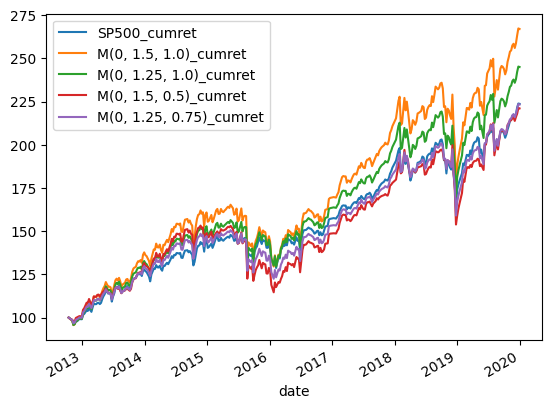

In [9]:
cols = [c for c in _df.columns if c.endswith("_cumret")]
_df.loc[:, cols].plot()